# Chater 15: Parameter Estimation to Hypothesis Testing: Building a Bayesian A/B Test

# Examples

I have never done a monte carlo simulation using scipy before, so I will follow along with the example from the chapter - which uses R - to make sure I get comparable results.

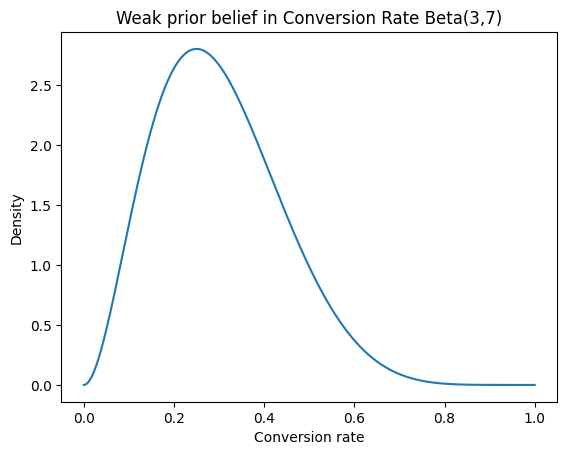

In [98]:
from dataclasses import dataclass

import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from typing import Self, Iterator

@dataclass
class DistDetails():
    alpha: int
    beta: int

    def __iter__(self) -> Iterator[int]:
        yield from (self.alpha, self.beta)
        

    def __add__(self, other: Self) -> Self:
        return DistDetails(self.alpha+other.alpha, self.beta+other.beta)

prior = DistDetails(3, 7)
prior_beta = beta(*prior)

fig, ax = plt.subplots(1,1)
x = np.linspace(0, 1, 1_000)
y = prior_beta.pdf(x)
ax.plot(x, y)
ax.set_title("Weak prior belief in Conversion Rate Beta(3,7)")
ax.set_ylabel("Density")
ax.set_xlabel("Conversion rate")
plt.show()

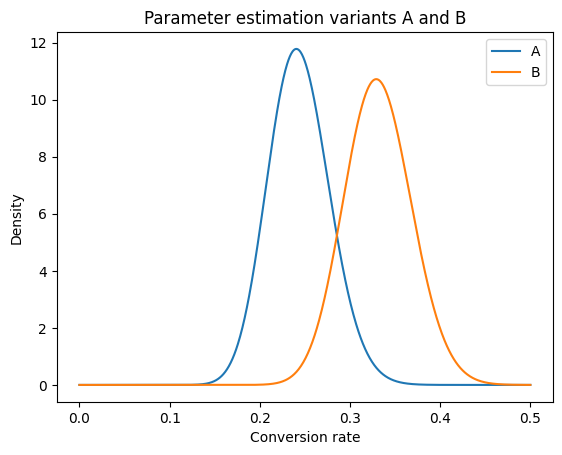

In [99]:
a_likelihood = DistDetails(36, 114)
b_likelihood = DistDetails(50, 100)

a_posterior = a_likelihood + prior
b_posterior = b_likelihood + prior

fig, ax = plt.subplots(1,1)
x = np.linspace(0, 0.5, 1_000)
y_a = beta.pdf(x, *a_posterior)
y_b = beta.pdf(x, *b_posterior)
ax.plot(x, y_a, label="A")
ax.plot(x, y_b, label="B")
ax.set_title("Parameter estimation variants A and B")
ax.set_ylabel("Density")
ax.set_xlabel("Conversion rate")
ax.legend()
plt.show()

b_proportion=0.96


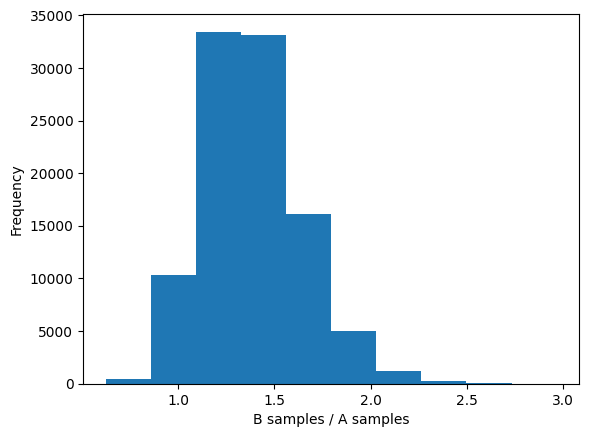

In [100]:
a_samples = beta.rvs(*a_posterior, size=100_000)
b_samples = beta.rvs(*b_posterior, size=100_000)

b_proportion = np.count_nonzero((b_samples > a_samples)) / a_samples.size
print(f"{b_proportion=:.2g}")

sample_ratios = b_samples / a_samples

fig, ax = plt.subplots(1,1)
ax.hist(sample_ratios)
ax.set_ylabel("Frequency")
ax.set_xlabel("B samples / A samples")
plt.show()

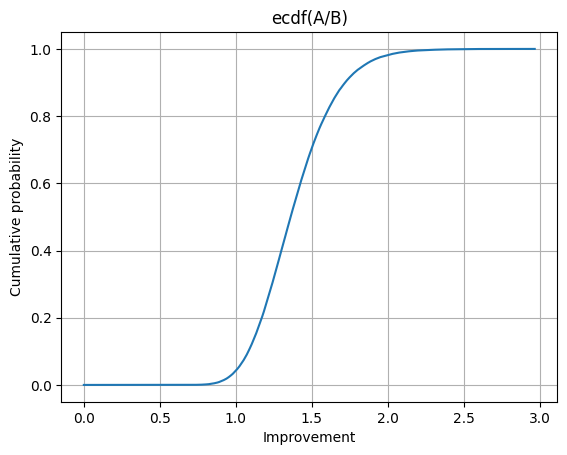

In [101]:
from statsmodels.distributions.empirical_distribution import ECDF

ratio_ecdf = ECDF(sample_ratios)
x = np.linspace(0, sample_ratios.max(), 1_000)

fig, ax = plt.subplots(1,1)

ax.plot(x, ratio_ecdf(x), label="A")
ax.grid(True)
ax.set_title("ecdf(A/B)")
ax.set_ylabel("Cumulative probability")
ax.set_xlabel("Improvement")
plt.show()


My results match the ones in the book.

## Exercises

1.  Suppose a director of marketing with many years of experience tells you he believes very strongly that the variant without images (B) won’t perform any differently than the original variant. How could you account for this in our model? Implement this change and see how your final conclusions change as well.
2.  The lead designer sees your results and insists that there's no way that variant B should perform better with no images.  She feels that you should assume the conversion rate for variant B is closer to 20 percent than 30 percent.  Implement a solution for this and again review the results of our analysis.
3.  Assume that being 95 percent certain means that you're more or less "convinced" of a hypothesis.  Also assume that there's no longer any limit to the number of emails you can send in your test.  If the true conversion for A is 0.25 and for B is 0.3, explore how many samples it would take to convince the director of marketing that B was in fact superior.  Explore the same for the lead designer.

### Exercise 1
> 1.  Suppose a director of marketing with many years of experience tells you he believes very strongly that the variant without images (B) won’t perform any differently than the original variant. How could you account for this in our model? Implement this change and see how your final conclusions change as well.

The way that you reflect this sort of beleif is by changing, in this case strengthening, your prior distribution.  The original analysis was carried out using Beta(3,7) and it can be made stronger by multiplying those arguments by an integer so that the ratio doesn't change but the magnitude increases.

Let us find what prior to use to reflect that the director of marketing is 95% sure that there should be no difference.

director_prior=DistDetails(alpha=387, beta=903)


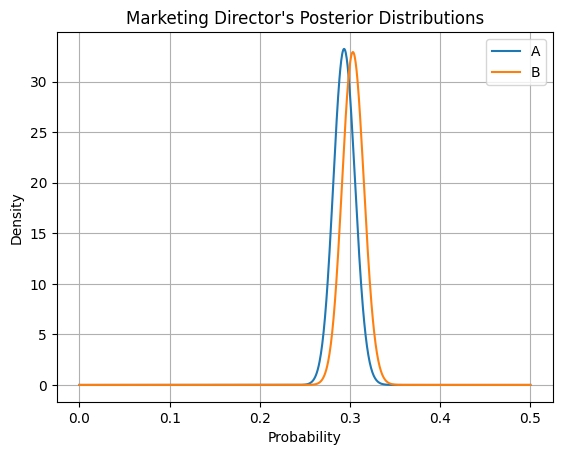

In [102]:
director_prior_initial = director_prior = DistDetails(3,7)

while True:
    lower_bound, upper_bound = beta.interval(0.95, director_prior.alpha, director_prior.beta)
    if abs(upper_bound - lower_bound) < 0.05:
        break
    else:
        director_prior += director_prior_initial
print(f"{director_prior=}")

director_a_posterior = director_prior + a_likelihood
director_b_posterior = director_prior + b_likelihood

fig, ax = plt.subplots(1,1)
x = np.linspace(0, 0.5, 1_000)
ax.plot(x, beta.pdf(x, *director_a_posterior), label="A")
ax.plot(x, beta.pdf(x, *director_b_posterior), label="B")
ax.legend()
ax.set_title("Marketing Director's Posterior Distributions")
ax.set_xlabel("Probability")
ax.set_ylabel("Density")
ax.grid(True)
plt.show()

The director's posterior distributions are much closer together, because they are both dominated by a strong prior beleif.

In [103]:
director_a_samples = beta.rvs(*director_a_posterior, size=100_000)
director_b_samples = beta.rvs(*director_b_posterior, size=100_000)

director_b_proportion = np.count_nonzero(director_b_samples > director_a_samples) / director_a_samples.size
print(f"Using the director's prior, the proportion of times B is better than A is {director_b_proportion:.2g}")

Using the director's prior, the proportion of times B is better than A is 0.72


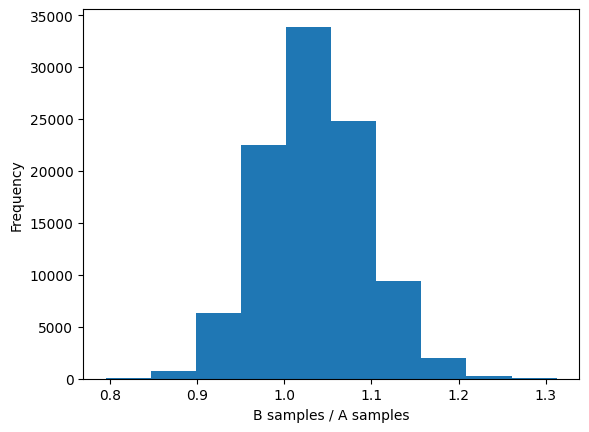

In [104]:
director_sample_ratios = director_b_samples / director_a_samples

fig, ax = plt.subplots(1,1)
ax.hist(director_sample_ratios)
ax.set_ylabel("Frequency")
ax.set_xlabel("B samples / A samples")
plt.show()


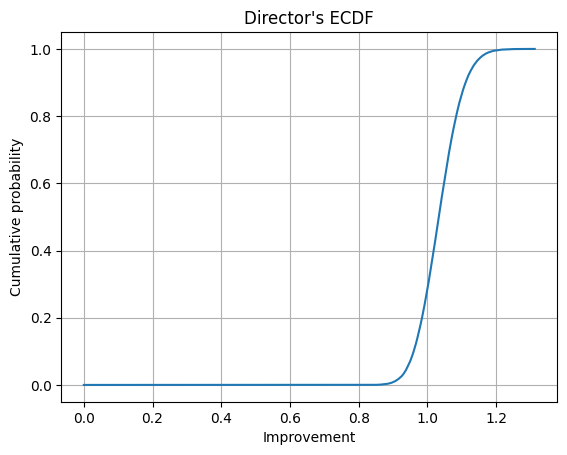

In [105]:
director_ecdf = ECDF(director_sample_ratios)
fig, ax = plt.subplots(1,1)
x = np.linspace(0, director_sample_ratios.max(), 1_000)
ax.plot(x, director_ecdf(x))
ax.set_title("Director's ECDF")
ax.set_xlabel("Improvement")
ax.set_ylabel("Cumulative probability")
ax.grid(True)
plt.show()

Using the director's prior dramatically reduces the confidence that B is beter from about 0.95 to about 0.75.

### Exercise 2

> 2.  The lead designer sees your results and insists that there's no way that variant B should perform better with no images.  She feels that you should assume the conversion rate for variant B is closer to 20 percent than 30 percent.  Implement a solution for this and again review the results of our analysis.

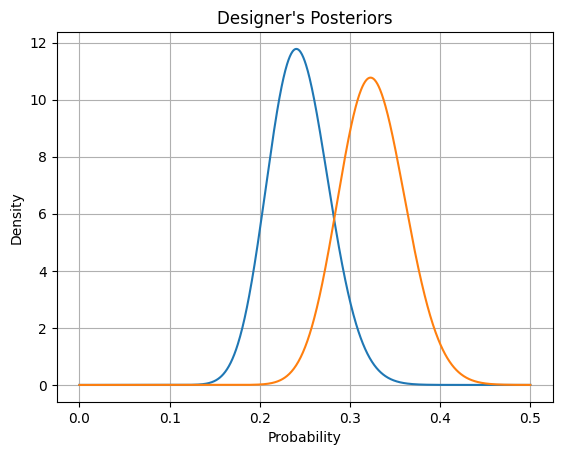

In [106]:
designer_prior_b = DistDetails(2,8)

designer_a_posterior = a_likelihood + prior
designer_b_posterior = b_likelihood + designer_prior_b

fig, ax = plt.subplots(1,1)
x = np.linspace(0, 0.5, 1_000)
ax.plot(x, beta.pdf(x, *designer_a_posterior), label="A")
ax.plot(x, beta.pdf(x, *designer_b_posterior), label="B")
ax.set_xlabel("Probability")
ax.set_ylabel("Density")
ax.set_title("Designer's Posteriors")
ax.grid(True)
plt.show()

In [107]:
designer_a_samples = beta.rvs(*designer_a_posterior, size=10_000)
designer_b_samples = beta.rvs(*designer_b_posterior, size=10_000)

designer_b_proportion = np.count_nonzero(designer_b_samples > designer_a_samples) / designer_a_samples.size
print(f"using the designer's priors, B is still supperior {designer_b_proportion:.2%} of the time")

using the designer's priors, B is still supperior 94.98% of the time


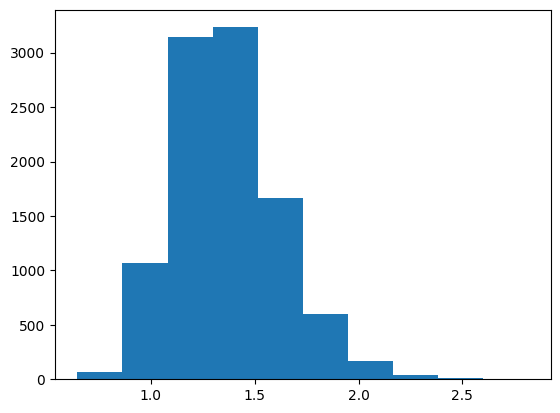

In [108]:
designer_sample_ratios = designer_b_samples / designer_a_samples
fig, ax = plt.subplots(1,1)
ax.hist(designer_sample_ratios)
plt.show()

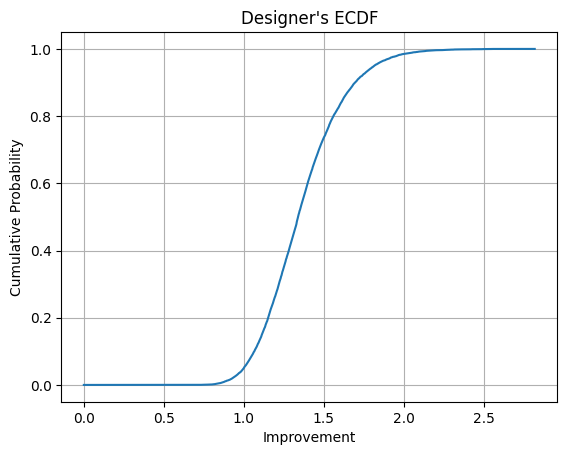

In [109]:
designer_ecdf = ECDF(designer_sample_ratios)

fig, ax = plt.subplots(1,1)
x = np.linspace(0, designer_sample_ratios.max(), 1_000)
ax.plot(x, designer_ecdf(x))
ax.set_title("Designer's ECDF")
ax.set_xlabel("Improvement")
ax.set_ylabel("Cumulative Probability")
ax.grid(True)

### Exercise 3

> 3.  Assume that being 95 percent certain means that you're more or less "convinced" of a hypothesis.  Also assume that there's no longer any limit to the number of emails you can send in your test.  If the true conversion for A is 0.25 and for B is 0.3, explore how many samples it would take to convince the director of marketing that B was in fact superior.  Explore the same for the lead designer.

I need to add samples and update the posterior distribuitons until their confidence that B is superior reaches 95%.  Since there's some randomness involved, I should probably test this more than once for each person's beleifs.

In [110]:
from scipy.stats import bernoulli
a_true = bernoulli(.25)
b_true = bernoulli(0.30)

#### Director

In [113]:
director_a_posterior_iterated = director_a_posterior
director_b_posterior_iterated = director_b_posterior
director_b_proportion_iterated = director_b_proportion

while director_b_proportion_iterated < 0.95:
    if a_true.rvs():
        director_a_posterior_iterated += DistDetails(1,0)
    else:
        director_a_posterior_iterated += DistDetails(0,1)
    if b_true.rvs():
        director_b_posterior_iterated += DistDetails(1,0)
    else:
        director_b_posterior_iterated += DistDetails(0,1)
    
    director_a_samples = beta.rvs(*director_a_posterior_iterated, size=100_000)
    director_b_samples = beta.rvs(*director_b_posterior_iterated, size=100_000)
    director_b_proportion_iterated = np.count_nonzero(director_b_samples > director_a_samples) / director_a_samples.size
print(f"Reaching {director_b_proportion_iterated:.2%} confidence took {director_b_posterior_iterated.alpha + director_b_posterior_iterated.beta} trials")

Reaching 95.11% confidence took 2497 trials


#### Designer

In [119]:
designer_a_posterior_iterated = designer_a_posterior
designer_b_posterior_iterated = designer_b_posterior

designer_b_proportion_iterated = designer_b_proportion

while designer_b_proportion_iterated < 0.95:
    if a_true.rvs():
        designer_a_posterior_iterated += DistDetails(1,0)
    else:
        designer_a_posterior_iterated += DistDetails(0,1)
    if b_true.rvs():
        designer_b_posterior_iterated += DistDetails(1,0)
    else:
        designer_b_posterior_iterated += DistDetails(0,1)
    
    designer_a_samples = beta.rvs(*designer_a_posterior_iterated, size=100_000)
    designer_b_samples = beta.rvs(*designer_b_posterior_iterated, size=100_000)
    designer_b_proportion_iterated = np.count_nonzero(designer_b_samples > designer_a_samples) / designer_a_samples.size
print(f"Reaching {designer_b_proportion_iterated:.2%} confidence took {designer_b_posterior_iterated.alpha + designer_b_posterior_iterated.beta} trials")

Reaching 95.52% confidence took 195 trials
